# N-Gram Language modeling

> "old school" language modeling based on counting tokens in data

In [ ]:
#| default_exp models.ngram

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [1]:
#| export
import torch.nn as nn
import torch
import torch.nn.functional as F

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict, List, Tuple, Optional, Set
from collections import Counter

import kenlm


ModuleNotFoundError: No module named 'kenlm'

https://github.com/karpathy/makemore

## Unigram

In [ ]:
#| export
class CharUnigram:
    def __init__(self, data:List[str]):
        self._count = {}
        self.total_count = 0
        self.unique_chars = set()
        for name in data:
            for c in name:
                self.unique_chars.update(c)
                if c in self._count:
                    self._count[c] += 1
                else:
                    self._count[c] = 1
                self.total_count += 1
        self._probs = {k:v/self.total_count for k,v in self._count.items()}
        self._count = self.sort_dict_by_value(self._count)
        self._probs = self.sort_dict_by_value(self._probs)
        self.unique_chars = sorted(self.unique_chars)
        self._stoi = {v:idx for idx,v in enumerate(self.unique_chars)}
        self._itos = {idx:v for idx,v in enumerate(self.unique_chars)}
        
    def __len__(self):
        return len(self.unique_chars)
    
    @staticmethod
    def sort_dict_by_value(dict:Dict, reverse:bool=True)->Dict:
        return {k:v for k,v in sorted(dict.items(), reverse=reverse, key=lambda x:x[1])}

    @property
    def counts(self)->Dict:
        return(self._count)

    @property
    def probs(self)->Dict:
        return(self._probs)

    @property
    def chars(self)->List:
        return self.unique_chars
        
    def stoi(self, char:str)->int:
        return(self._stoi[char])
    
    def itos(self, idx:int)->str:
        return(self._itos[idx])
    
    def sample(self)->str:
        # get probs for order list of characters to build prob table
        prob_distrib = torch.tensor([self._probs[k] for k in self.unique_chars])
        idx = int(torch.multinomial(prob_distrib,num_samples=1,replacement=True))
        return(self._itos[idx])
        

### Usage

In [ ]:
# without pandas
with open('../data/text/names.txt', 'r') as f:
    list_of_words = f.read().splitlines()
# with pandas
df = pd.read_csv('../data/text/names.txt', names=['name'], header=None)
list_of_words = list(df.head().name)

unigram = CharUnigram(list_of_words)
print("sorted counts: ", unigram.counts)
print("sorted probs: ", unigram.probs)
print(len(unigram))
print(unigram.chars)
print(unigram._stoi)
print(unigram.stoi('a'))
print(unigram.itos(0))

sorted counts:  {'a': 7, 'i': 4, 'l': 3, 'e': 2, 'm': 2, 'o': 2, 'v': 2, 's': 2, 'b': 1, 'p': 1, 'h': 1}
sorted probs:  {'a': 0.25925925925925924, 'i': 0.14814814814814814, 'l': 0.1111111111111111, 'e': 0.07407407407407407, 'm': 0.07407407407407407, 'o': 0.07407407407407407, 'v': 0.07407407407407407, 's': 0.07407407407407407, 'b': 0.037037037037037035, 'p': 0.037037037037037035, 'h': 0.037037037037037035}
11
['a', 'b', 'e', 'h', 'i', 'l', 'm', 'o', 'p', 's', 'v']
{'a': 0, 'b': 1, 'e': 2, 'h': 3, 'i': 4, 'l': 5, 'm': 6, 'o': 7, 'p': 8, 's': 9, 'v': 10}
0
a


<Axes: >

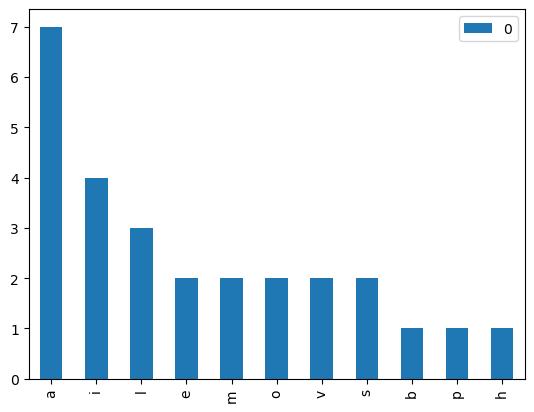

In [ ]:
df = pd.DataFrame.from_dict(unigram.counts, orient='index')
df.plot(kind='bar')

<Axes: >

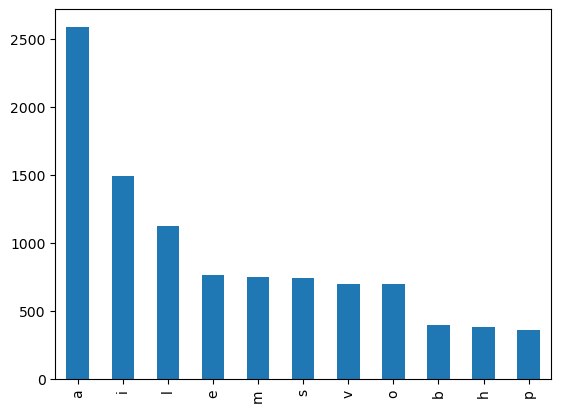

In [ ]:
samples = []
for i in range(10000):
    s = unigram.sample()
    samples.append(s)

# sampled
count = Counter([c for w in samples for c in w])
df = pd.DataFrame.from_dict(count, orient='index')
df[0].sort_values(ascending=False).plot(kind='bar')

## Bigram

In [ ]:
class CharBigram():
    def __init__(self):
        pass
    

### Usage

In [ ]:
# data
with open('../data/text/names.txt', 'r') as f:
    data = f.read().splitlines()
print("first lines of text: ", data[:10])

# data = ["this is a text"]

first lines of text:  ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [ ]:
# bigram counts
bigrams = {}
unique_tokens = set()
for name in data:
    line = list(name)
    unique_tokens.update(line)
    line.append('<stop>')
    line.insert(0, '<stop>')
    for i,v in enumerate(range(len(line)-1)):
        bigram = (line[i], line[i+1])
        if bigram in bigrams:
            bigrams[bigram] += 1
        else:
            bigrams[bigram] = 1

# print("unsorted: ", list(bigrams)[:10])
# print("sorted: ", sort_dict_by_value(bigrams))


### Numericalization

In [ ]:
tokens = sorted(unique_tokens)
# use same for start & stop in this case (separate lines of names)
# tokens.append('<start>')
tokens.append('<stop>')
print(tokens)
stoi = {v:i for i,v in enumerate(tokens)}
itos = {i:v for i, v in enumerate(tokens)}
print(stoi, itos)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '<stop>']
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '<stop>': 26} {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '<stop>'}


### Matrix representation

In [ ]:
n_toks = len(tokens)
print(n_toks)
N = torch.zeros((n_toks, n_toks)).long()
print(N.shape)

27
torch.Size([27, 27])


<matplotlib.image.AxesImage>

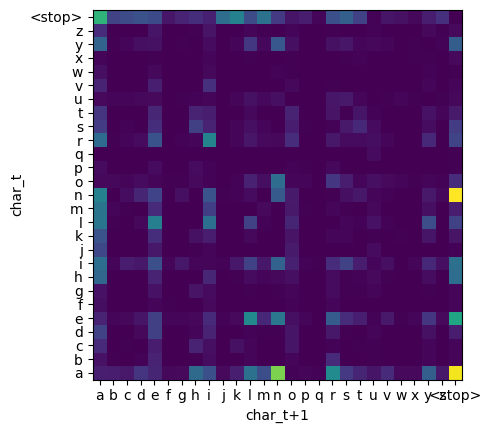

In [ ]:
for bigram, value in bigrams.items():
    idx1, idx2 = stoi[bigram[0]], stoi[bigram[1]]
    N[idx1, idx2] = value

plt.xlabel('char_t+1')
plt.ylabel('char_t')
i = [i for i, v in itos.items()]
v = [v for i,v in itos.items()]
plt.xticks(i, v)
plt.yticks(i, v)
plt.imshow(N, origin='lower')

### From counts to probabilities

In [ ]:
print(N)

tensor([[ 556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568, 2528,
         1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,  182,
         2050,  435, 6640],
        [ 321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,  103,
            0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,    0,
           83,    0,  114],
        [ 815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,  116,
            0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,    3,
          104,    4,   97],
        [1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,   60,
           30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,    0,
          317,    1,  516],
        [ 679,  121,  153,  384, 1271,   82,  125,  152,  818,   55,  178, 3248,
          769, 2675,  269,   83,   14, 1958,  861,  580,   69,  463,   50,  132,
         1070,  181, 3983],
        [ 242,    0,    0,    0,  123,   44,    1,

<matplotlib.image.AxesImage>

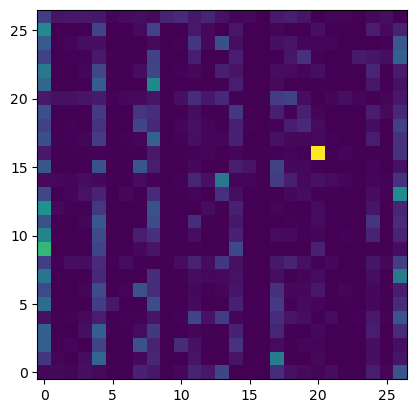

In [ ]:
# smoothing avoids having log(0) = inf when computing NLL loss
smoothing = 1
P = (N.float()+smoothing) / N.sum(1,keepdim=True)
plt.imshow(P, origin='lower')

In [ ]:
row_6 = (N[6,:]/N[6,:].sum())
print(row_6)
print(row_6.sum())

tensor([0.1713, 0.0016, 0.0000, 0.0099, 0.1733, 0.0005, 0.0130, 0.1868, 0.0986,
        0.0016, 0.0000, 0.0166, 0.0031, 0.0140, 0.0431, 0.0000, 0.0000, 0.1043,
        0.0156, 0.0161, 0.0441, 0.0005, 0.0135, 0.0000, 0.0161, 0.0005, 0.0560])
tensor(1.0000)


In [ ]:
p = P[6, :]
print(p.sum(), p.max(), torch.argmax(p))


tensor(1.0140) tensor(0.1873) tensor(7)


### Sampling

In [ ]:
for i in range(10):
    res = []
    prev = stoi['<stop>']
    while True:
        # max prob sampling
        next = int(torch.argmax(P[prev, :]))
        # multinomial sampling
        next = int(torch.multinomial(P[prev,:],num_samples=1,replacement=True))
        if next == stoi['<stop>']:
            print(''.join(res))
            break
        else:
            res.append(itos[next])
            prev = next


ash
geleeraby
kll
velorionzl
bstaya
aniy
agiailababunieah
dah
k
amazi


### Log likelihood loss function

In [ ]:
bigram_p = {}
for bigram, value in bigrams.items():
    idx1, idx2 = stoi[bigram[0]], stoi[bigram[1]]
    bigram_p[bigram] = P[idx1,idx2]

print(bigram_p)

{('<stop>', 'e'): tensor(0.0478), ('e', 'm'): tensor(0.0377), ('m', 'm'): tensor(0.0254), ('m', 'a'): tensor(0.3901), ('a', '<stop>'): tensor(0.1960), ('<stop>', 'o'): tensor(0.0123), ('o', 'l'): tensor(0.0781), ('l', 'i'): tensor(0.1777), ('i', 'v'): tensor(0.0153), ('v', 'i'): tensor(0.3545), ('i', 'a'): tensor(0.1382), ('<stop>', 'a'): tensor(0.1377), ('a', 'v'): tensor(0.0246), ('v', 'a'): tensor(0.2499), ('<stop>', 'i'): tensor(0.0185), ('i', 's'): tensor(0.0744), ('s', 'a'): tensor(0.1483), ('a', 'b'): tensor(0.0160), ('b', 'e'): tensor(0.2480), ('e', 'l'): tensor(0.1591), ('l', 'l'): tensor(0.0964), ('l', 'a'): tensor(0.1880), ('<stop>', 's'): tensor(0.0642), ('s', 'o'): tensor(0.0656), ('o', 'p'): tensor(0.0121), ('p', 'h'): tensor(0.1998), ('h', 'i'): tensor(0.0959), ('<stop>', 'c'): tensor(0.0482), ('c', 'h'): tensor(0.1883), ('h', 'a'): tensor(0.2948), ('a', 'r'): tensor(0.0964), ('r', 'l'): tensor(0.0326), ('l', 'o'): tensor(0.0496), ('o', 't'): tensor(0.0150), ('t', 't'): 

In [ ]:
bigram_p_sorted = {k: v.float() for k, v in sorted(bigram_p.items(), reverse=True, key=lambda x: x[1])}
print(bigram_p_sorted)

{('q', 'u'): tensor(0.7610), ('j', 'a'): tensor(0.5083), ('m', 'a'): tensor(0.3901), ('n', '<stop>'): tensor(0.3691), ('z', 'a'): tensor(0.3590), ('v', 'i'): tensor(0.3545), ('k', 'a'): tensor(0.3437), ('b', 'r'): tensor(0.3187), ('h', '<stop>'): tensor(0.3164), ('o', 'n'): tensor(0.3040), ('w', 'a'): tensor(0.3025), ('h', 'a'): tensor(0.2948), ('f', 'a'): tensor(0.2685), ('v', 'a'): tensor(0.2499), ('b', 'e'): tensor(0.2480), ('r', 'i'): tensor(0.2389), ('d', 'a'): tensor(0.2373), ('x', '<stop>'): tensor(0.2367), ('d', 'e'): tensor(0.2336), ('c', 'a'): tensor(0.2310), ('v', 'e'): tensor(0.2211), ('y', 'a'): tensor(0.2193), ('l', 'e'): tensor(0.2093), ('y', '<stop>'): tensor(0.2054), ('p', 'a'): tensor(0.2047), ('p', 'h'): tensor(0.1998), ('a', '<stop>'): tensor(0.1960), ('e', '<stop>'): tensor(0.1951), ('p', 'e'): tensor(0.1930), ('m', 'i'): tensor(0.1893), ('c', 'h'): tensor(0.1883), ('l', 'a'): tensor(0.1880), ('g', 'h'): tensor(0.1873), ('y', 'n'): tensor(0.1869), ('r', 'a'): tenso

In [ ]:
# likelihood of full corpus = product of all bigram prods
l = 0
for bigram, prob in bigram_p_sorted.items():
    l += torch.log(prob)

# negative log likelihood loss nll
nll = -l /len(bigram_p_sorted)
print(nll)

tensor(4.4447)


### Generate training data

In [ ]:
word = "this"
sample = [(word[i], word[i+1]) for i,c in enumerate(word) if i < len(word)-1]
print(list(zip(*sample)))

[('t', 'h', 'i'), ('h', 'i', 's')]


In [ ]:
xs, ys = [], []
for word in data:
    sample = [(stoi[word[i]], stoi[word[i+1]]) for i,c in enumerate(word) if i < len(word)-1]
    x, y = list(zip(*sample)) # inverse of zip
    xs.append(torch.tensor(x))
    ys.append(torch.tensor(y))

In [ ]:
print(xs[:3], ys[:3])

[tensor([ 4, 12, 12]), tensor([14, 11,  8, 21,  8]), tensor([ 0, 21])] [tensor([12, 12,  0]), tensor([11,  8, 21,  8,  0]), tensor([21,  0])]


### 1-hot encoded input

In [ ]:
enc = [F.one_hot(x, num_classes=len(tokens)).float() for x in xs]
print(enc[:3])

[tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.

<matplotlib.image.AxesImage>

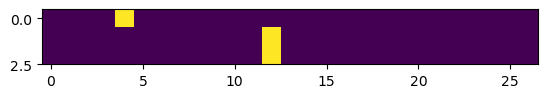

In [ ]:
plt.imshow(enc[0])

In [ ]:
X = enc[0]
print(X.shape)

torch.Size([3, 27])


### 'Neural net' modeling
we model the transition probability matrix by neural net activations

In [ ]:
W = torch.randn(27, 27)

In [ ]:
logits = X @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
print(probs)

tensor([[0.0337, 0.0199, 0.0826, 0.0366, 0.0263, 0.0144, 0.0057, 0.0167, 0.0242,
         0.0250, 0.0264, 0.2481, 0.0328, 0.0063, 0.0064, 0.0177, 0.0164, 0.0161,
         0.0125, 0.0134, 0.0285, 0.0894, 0.0408, 0.0117, 0.0030, 0.0229, 0.1224],
        [0.0113, 0.0214, 0.0160, 0.1308, 0.0192, 0.0053, 0.0200, 0.0808, 0.0523,
         0.0327, 0.0161, 0.0189, 0.0030, 0.0153, 0.0244, 0.0132, 0.0052, 0.0366,
         0.0078, 0.0281, 0.0100, 0.0147, 0.0354, 0.0152, 0.1898, 0.0428, 0.1339],
        [0.0113, 0.0214, 0.0160, 0.1308, 0.0192, 0.0053, 0.0200, 0.0808, 0.0523,
         0.0327, 0.0161, 0.0189, 0.0030, 0.0153, 0.0244, 0.0132, 0.0052, 0.0366,
         0.0078, 0.0281, 0.0100, 0.0147, 0.0354, 0.0152, 0.1898, 0.0428, 0.1339]])


## KenLM
We refer to efficient kenlm implementation for larger n-gram models usable for production

In [ ]:
#| export 

class KenLM:
    def __init__(self, arpa_path:str, vocab:List):
        # TODO: deal with zipped arpa models
        self.model = kenlm.LanguageModel(arpa_path)
        self.partial_text = []
        self.partial_score = 0.0
        # init new sentence
        self.s1 = kenlm.State()
        self.s2 = kenlm.State()
        self.model.BeginSentenceWrite(self.s1)
        self.vocab = vocab

    def init_vocab(self, vocab_path):
        with open(vocab_path) as f: self.vocab = f.read().splitlines()
    
    def new_sentence_init(self):
        self.partial_text = []
        self.partial_score = 0.0
        self.s1 = kenlm.State()
        self.s2 = kenlm.State()
        self.model.BeginSentenceWrite(self.s1)
    
    def append(self, word:str):
        # add word to beam and update probs
        if word == '.':
            self.partial_score += self.model.BaseScore(self.s1, word, self.s2)
            self.partial_score += self.model.BaseScore(self.s2, '</s>', self.s1)
            self.partial_text.append(word)
        else:
            self.partial_score += self.model.BaseScore(self.s1, word, self.s2)
            # input <=> output state
            self.s1, self.s2 = self.s2, self.s1
            self.partial_text.append(word)
    
    def peek(self, word:str, log_prob:bool=True)->float:
        if log_prob:
            # check prob of next word given context without update state
            res = self.partial_score+self.model.BaseScore(self.s1, word, self.s2)
        else:
            res = 10**(self.partial_score+self.model.BaseScore(self.s1, word, self.s2))
        return(res)

    def sentence_score(self, sentence:str)->float:
        return(self.model.score(sentence))

    def partial_sentence_score(self, sentence:str)->float:
        return(self.model.score(sentence, eos=False))
        
    def nbest(self, n:int, log_prob:bool=True):
        if not self.vocab:
            print('need to init vocab')
        res = []
        for word in self.vocab:
            res.append((word, self.peek(word, log_prob)))

        return sorted(res, key=lambda x: x[1], reverse=True)[:n]

    @property
    def score(self)->float:
        return(self.partial_score)

    @property
    def text(self)->str:
        return(' '.join(self.partial_text))
    

### Preprocess data into kenlm format
tokens separated by space with new sentence at each line

In [ ]:
df = pd.read_csv('../data/text/names.txt', header=None, names=['name']) 
df = df.name.apply(lambda x: list(x)) # str into list of char
# df.apply(lambda x: x.append('<eos>')) # if eos needed
print(df.head())
df_toks = df.str.join(' ') # for kenlm input format tokens are separated by space
print(df_toks.head())


0                [e, m, m, a]
1          [o, l, i, v, i, a]
2                   [a, v, a]
3    [i, s, a, b, e, l, l, a]
4          [s, o, p, h, i, a]
Name: name, dtype: object
0            e m m a
1        o l i v i a
2              a v a
3    i s a b e l l a
4        s o p h i a
Name: name, dtype: object


#### Unique tokens

In [ ]:
df.head()
# for row in df.iterrows():
#     print(row)
tokens = set()
for k,v in df.items():
    tokens.update(list(v))

print(tokens)
len(tokens)

{'f', 'e', 'q', 't', 'a', 'c', 'x', 'p', 'm', 'z', 'u', 'l', 'j', 'd', 'h', 'w', 'v', 'o', 'i', 'r', 'b', 'g', 'n', 'y', 's', 'k'}


26

#### Save data to kenlm format for training

In [ ]:
data_file = df.to_csv('../data/text/names.kenlm.txt', header=None, index=None)
! bzip2 -kz ../data/text/names.kenlm.txt
! bzcat ../data/text/names.kenlm.txt.bz2 | head

bzip2: Output file ../data/names.kenlm.txt.bz2 already exists.
"['e', 'm', 'm', 'a']"
"['o', 'l', 'i', 'v', 'i', 'a']"
"['a', 'v', 'a']"
"['i', 's', 'a', 'b', 'e', 'l', 'l', 'a']"
"['s', 'o', 'p', 'h', 'i', 'a']"
"['c', 'h', 'a', 'r', 'l', 'o', 't', 't', 'e']"
"['m', 'i', 'a']"
"['a', 'm', 'e', 'l', 'i', 'a']"
"['h', 'a', 'r', 'p', 'e', 'r']"
"['e', 'v', 'e', 'l', 'y', 'n']"

bzcat: I/O or other error, bailing out.  Possible reason follows.
bzcat: Broken pipe
	Input file = ../data/names.kenlm.txt.bz2, output file = (stdout)


### Train KenLM n-gram model
https://lukesalamone.github.io/posts/running-simple-language-model/

KenLM requires data to be one sentence per line lowercase

In [ ]:
! if [ ! -f "../data/text/names.2gram.arpa" ]; then lmplz --discount_fallback -o 2 < ../data/text/names.kenlm.txt.bz2>../data/text/names.2gram.arpa; fi

In [ ]:
! if [ ! -f "../data/text/names.2gram.kenlm" ]; then build_binary ../data/text/names.2gram.arpa ../data/text/names.2gram.kenlm; fi

Reading ../data/names.2gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
SUCCESS


#### Test original Kenlm python api probs

In [ ]:
model = kenlm.LanguageModel('../data/text/names.2gram.kenlm')
sentence = "emma"
tokenized = "e m m a"
# model.score("emma", bos = False, eos = False)
words = ['<s>'] + list(sentence) + ['</s>']
print(words)
final = 0
for i, (prob, length, oov) in enumerate(model.full_scores(tokenized)):
    print(f'words: {words[i:i+length]} index:{i}, prob:{prob}, length:{length}, oov:{oov}')
    final += prob

print(final)
print(model.score("e m m a"))
print(f'prob <s> e: {model.score("e", bos=True, eos=False)}')
print(f'prob e: {model.score("e", bos=False, eos=False)}')
print(f'prob <s> e m: {model.score("e m", bos=True, eos=False)}')
print(f'prob e m: {model.score("e m", bos=False, eos=False)}')
state = kenlm.State()
state2 = kenlm.State()
model.BeginSentenceWrite(state)
accum = 0
accum += model.BaseScore(state, "e", state2)
print(f'prob <s> e: {accum}')
state, state2 = state2, state
accum += model.BaseScore(state, "m", state2)
print(f'prob <s> e m: {accum}')


['<s>', 'e', 'm', 'm', 'a', '</s>']
words: ['<s>'] index:0, prob:-6.039403915405273, length:1, oov:True
words: ['e'] index:1, prob:-3.074934959411621, length:1, oov:True
words: ['m'] index:2, prob:-3.074934959411621, length:1, oov:True
words: ['m'] index:3, prob:-3.074934959411621, length:1, oov:True
words: ['a'] index:4, prob:-1.7287936210632324, length:1, oov:False
-16.99300241470337
-16.99300193786621
prob <s> e: -6.039403915405273
prob e: -3.074934959411621
prob <s> e m: -9.114338874816895
prob e m: -6.149869918823242
prob <s> e: -6.039403915405273
prob <s> e m: -9.114338874816895


#### Define LM vocabulary

In [ ]:
# add special tokens to vocabulary
tokens.add('<s>')
tokens.add('</s>')
tokens.add('<unk>')
print(tokens, len(tokens))
vocab = list(tokens)

{'f', 'e', 'q', 't', 'a', 'c', 'x', 'p', 'm', 'z', '<s>', 'u', 'l', 'j', 'd', 'h', 'w', 'v', '<unk>', 'o', 'i', 'r', '</s>', 'b', 'g', 'n', 'y', 's', 'k'} 29


### Inference / Sampling from prob distributions

In [ ]:
lm = KenLM('../data/text/names.2gram.kenlm', vocab)
init_char = '<s> e m m'
# probs = lm.nbest(len(vocab), log_prob=False)
# print(np.sum([p for char, p in probs]))
# res = [init_char]
# next = int(torch.multinomial(P[prev,:],num_samples=1,replacement=True))
for i in range(50):
    lm.new_sentence_init()
    lm.append(init_char)
    while True:
        # nbest probs at current state
        probs = lm.nbest(len(vocab), log_prob=False)
        # print(probs)
        # print(np.sum(probs))
        # sample from prob distribution
        try:
            index_next = int(torch.multinomial(torch.tensor([prob for char, prob in probs]),num_samples=1,replacement=True))
        except:
            print("probs too small")
            break
        char_next = probs[index_next][0]
        lm.append(char_next)
        # print(init_char + '<s>')
        if char_next == '</s>' or char_next == '<s>' and lm.text != init_char and (lm.text != init_char+' <s>'):
            print(lm.text.replace(' ', ''))
            break



<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s></s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s>l<s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s>h<s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>
<s>emm<s><s>


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()